In [1]:
# Packages for numerics & dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


In [2]:
# Load the dataset.
df = pd.read_csv('waze_dataset.csv')

In [3]:
#performing required cleaning & EDA for logistic regression modelling.
#drop ID since it is not required for analysis.
df = df.drop('ID', axis=1)
df['label'].value_counts(normalize=True)


retained    0.822645
churned     0.177355
Name: label, dtype: float64

In [4]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


colums such as sessions ,drives ,total_sessions ,total_navigations_fav1 , total_navigations_fav2 ,driven_km_drives,
duration_minutes_drives have max values that are multiple standard deviations above the 75th percentile. 
This could indicate outliers in these variables.

In [8]:
#From erlier data , it is evident that churn rate correlates with distance driven per driving day in the last month.
#New feature 'Km_per_driving_day' is created to capture this information.
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [9]:
# The presence of 0 in driving_days column results in infinity.convert infinity to zero.
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [12]:
#New feature called 'professional_driver' is created ,that is a 1 for users who had 60 or more drives and drove on 15+ days in the last month.
df['professional_driver']= np.where((df['drives']>=60)&(df['driving_days']>=15),1,0)

In [13]:
# Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

The churn rate for professional drivers is 7.6%,
while the churn rate for non-professionals is 19.9%. 
This seems like it could add predictive signal to the model.

From previous EDA it was evident that there is no evidence of a
non-random cause of the 700 missing values in the label column, and because 
these observations comprise less than 5% of the data, the rows with missing 
data will be dropped.

In [15]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

In [16]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [17]:
# To Check if outliers are imputed.
df.describe()


,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


In [18]:
# Encode categorical values 
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [19]:
# Checking collinearity among X predictors, to ensure there is little to no multicollinearity among x predictors
# Generate a correlation matrix
df.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259


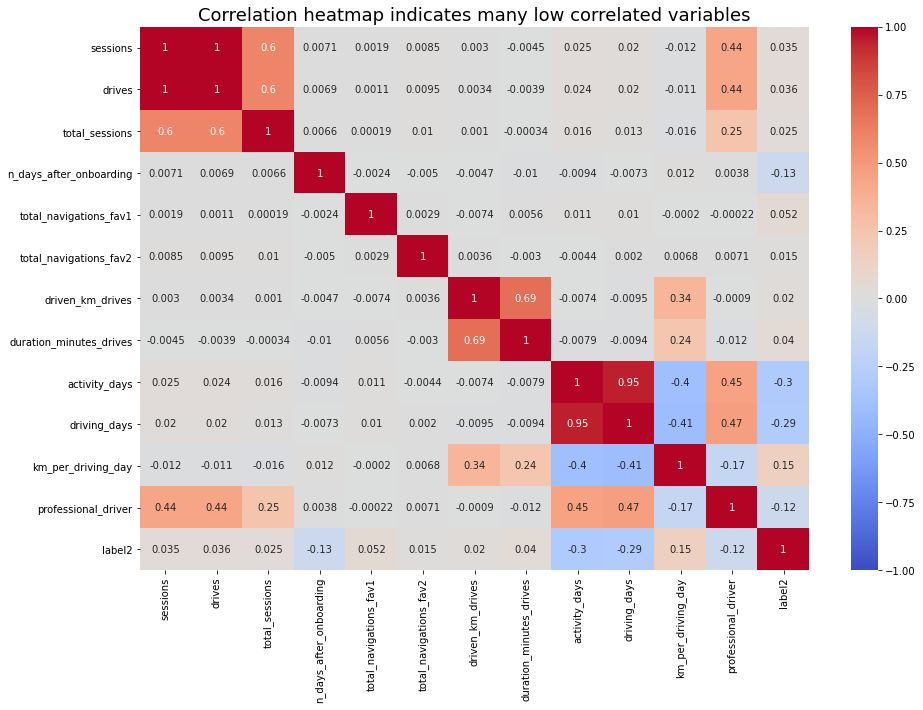

In [20]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

If there are predictor variables that have a Pearson correlation coefficient value greater than the absolute value of 0.7,
these variables are strongly multicollinear.
from the above observation , it can be interpreted that two sets of variables are multicollinear with each other. 
sessions and drives: 1.0
driving_days and activity_days: 0.95

In [25]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [27]:
#the features that has more correlation with target variable is selected for modeling
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [28]:
# Isolate target variable
y = df['label2']

In [29]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [30]:
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108.0,186.192746,3116,243.0,124.0,8898.716275,4668.180092,24,612.305861,1,1
11899,2.0,3.487590,794,114.0,18.0,3286.545691,1780.902733,5,3286.545691,0,1
10937,139.0,347.106403,331,4.0,7.0,7400.838975,2349.305267,15,616.736581,0,0
669,108.0,455.439492,2320,11.0,4.0,6566.424830,4558.459870,18,410.401552,1,1
8406,10.0,89.475821,2478,135.0,0.0,1271.248661,938.711572,27,74.779333,0,1


In [31]:
#It is important to add penalty = 'none' since your predictors are unscaled.
model = LogisticRegression(penalty='none', max_iter=400)
# Fit the model on X_train , y_train.
model.fit(X_train, y_train)

LogisticRegression(max_iter=400, penalty='none')

In [32]:
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001913
total_sessions             0.000327
n_days_after_onboarding   -0.000406
total_navigations_fav1     0.001232
total_navigations_fav2     0.000931
driven_km_drives          -0.000015
duration_minutes_drives    0.000109
activity_days             -0.106032
km_per_driving_day         0.000018
professional_driver       -0.001529
device2                   -0.001041
dtype: float64

In [33]:
model.intercept_

array([-0.00170675])

In [35]:
# Get the predicted probabilities of the training data
#The first column is the probability of the user not churning, and the second column is the probability of the user churning.
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963477, 0.06036523],
       [0.61967313, 0.38032687],
       [0.76463196, 0.23536804],
       ...,
       [0.91909646, 0.08090354],
       [0.85092102, 0.14907898],
       [0.93516299, 0.06483701]])

In [38]:
# Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

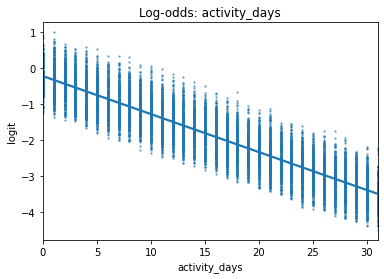

In [39]:
# Plot regplot of `activity_days` log-odds
# This is done to Verify the linear relationship between X and the estimated log odds (known as logits) by making a regplot.
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

In [41]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [42]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8237762237762237

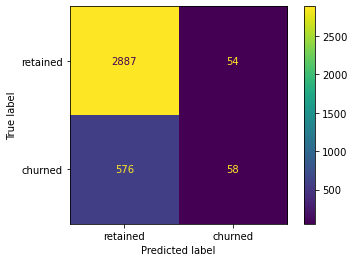

In [44]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'])
disp.plot();

In [45]:
# Calculate precision manually
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.5178571428571429

In [46]:
# Calculate recall manually
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.0914826498422713

In [47]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



The model has mediocre precision and very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

In [48]:
# Visualizing the importance of the model's features by plotting bar graph of model's coefficients.
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance


[('drives', 0.0019133767249960155),
 ('total_navigations_fav1', 0.0012317564051820319),
 ('total_navigations_fav2', 0.0009314814337507645),
 ('total_sessions', 0.00032706209497397555),
 ('duration_minutes_drives', 0.00010909315818517379),
 ('km_per_driving_day', 1.8222700661650677e-05),
 ('driven_km_drives', -1.4860046665747797e-05),
 ('n_days_after_onboarding', -0.00040647744551980045),
 ('device2', -0.0010412181581601252),
 ('professional_driver', -0.001528505060242999),
 ('activity_days', -0.10603202862395603)]

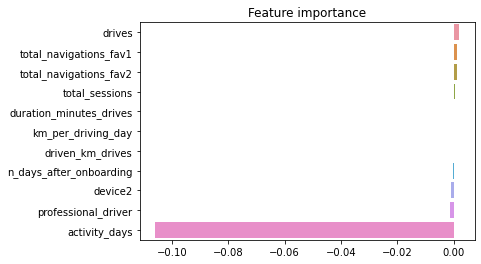

In [49]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');